In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder, Binarizer
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline


In [4]:
df = pd.read_csv('spambase_csv.xls')
target = 'class'

df_gauss = df.copy()
df_multi = df.copy()
df_berno = df.copy()

In [5]:
def is_normal(series):
    skew = series.skew()
    return -0.5 <= skew <= 0.5

def has_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((series < (Q1 - 1.5 * IQR)) | (series > (Q3 + 1.5 * IQR))).sum()
    return outliers > 0

In [6]:
# Separate types
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = [col for col in numerical_cols if col != target]

# --- Missing Values Handling ---
for col in df.columns:
    if df[col].isnull().sum() > 0:
        if col in numerical_cols:
            if is_normal(df[col]):
                if has_outliers(df[col]):
                    df[col].fillna(df[col].median(), inplace=True)
                else:
                    df[col].fillna(df[col].mean(), inplace=True)
            else:
                df[col].fillna(df[col].median(), inplace=True)
        else:
            df[col].fillna(df[col].mode()[0], inplace=True)  # categorical

# --- Outlier Removal (for numerical columns only) ---
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    #df = df[~((df[col] < Q1 - 1.5 * IQR) | (df[col] > Q3 + 1.5 * IQR))]

In [7]:
# --- Drop rows where target is missing ---
df.dropna(subset=[target], inplace=True)

In [8]:
# --- Gaussian NB preprocessing ---
le = LabelEncoder()
df_gauss[target] = le.fit_transform(df_gauss[target])
for col in categorical_cols:
    df_gauss = pd.get_dummies(df_gauss, columns=categorical_cols)

for col in numerical_cols:
    if is_normal(df_gauss[col]):
        scaler = StandardScaler()
    elif has_outliers(df_gauss[col]):
        scaler = StandardScaler()
    else:
        scaler = MinMaxScaler()
    df_gauss[[col]] = scaler.fit_transform(df_gauss[[col]])

# --- Multinomial NB preprocessing ---
le = LabelEncoder()
df_multi[target] = le.fit_transform(df_multi[target])
df_multi = pd.get_dummies(df_multi, columns=categorical_cols, drop_first=False)

for col in numerical_cols:
    scaler = MinMaxScaler()
    df_multi[[col]] = scaler.fit_transform(df_multi[[col]])

# --- Bernoulli NB preprocessing ---
le = LabelEncoder()
df_berno[target] = le.fit_transform(df_berno[target])
df_berno = pd.get_dummies(df_berno, columns=categorical_cols, drop_first=True)

for col in numerical_cols:
    binarizer = Binarizer(threshold=0.0)
    df_berno[[col]] = binarizer.fit_transform(df_berno[[col]])

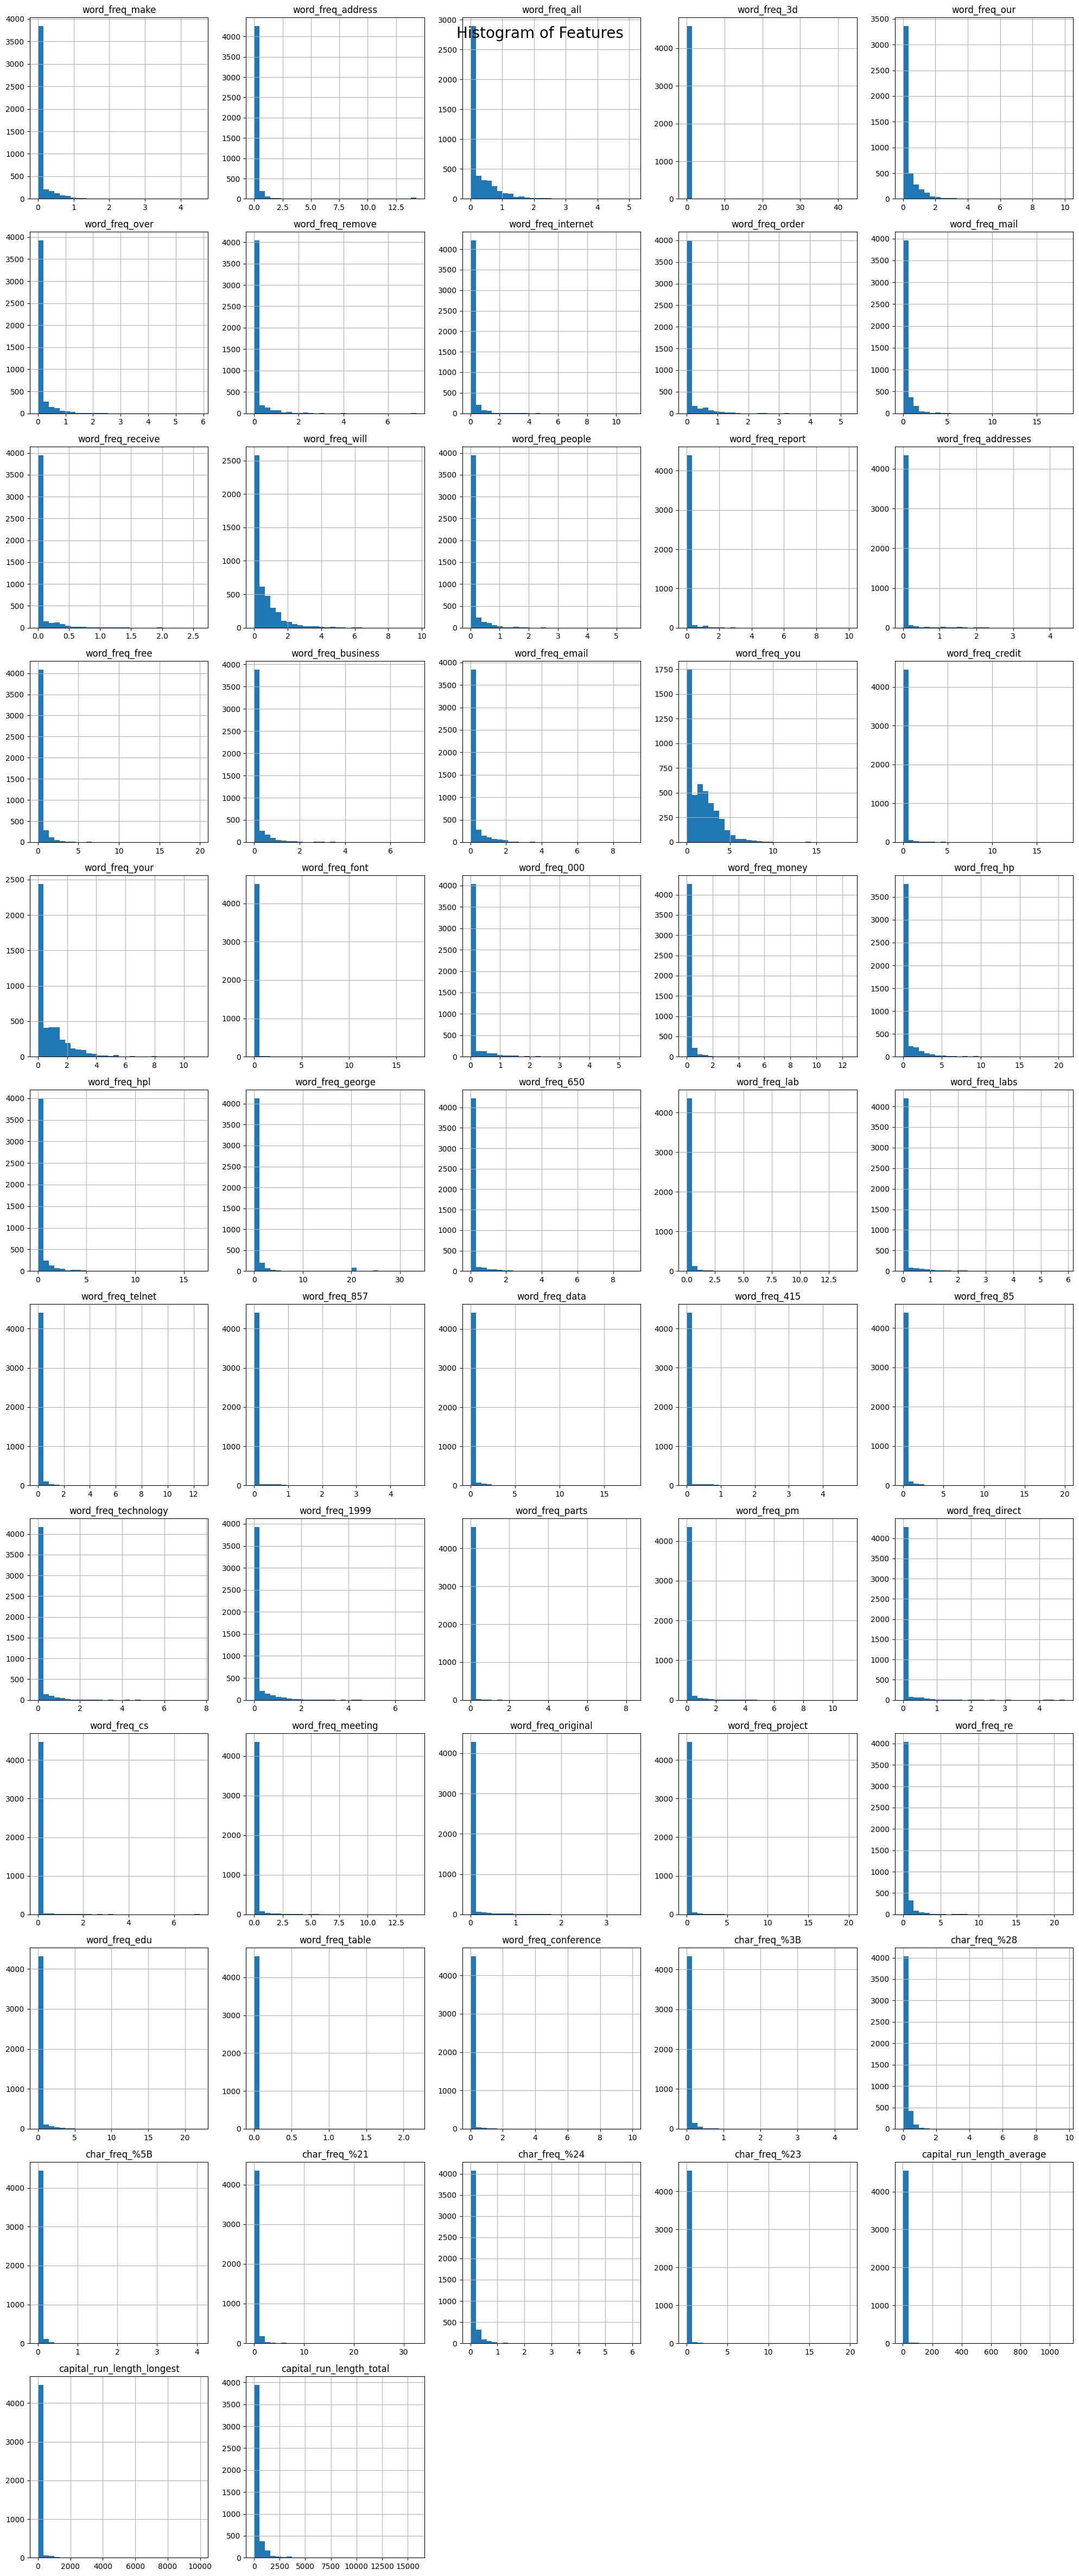

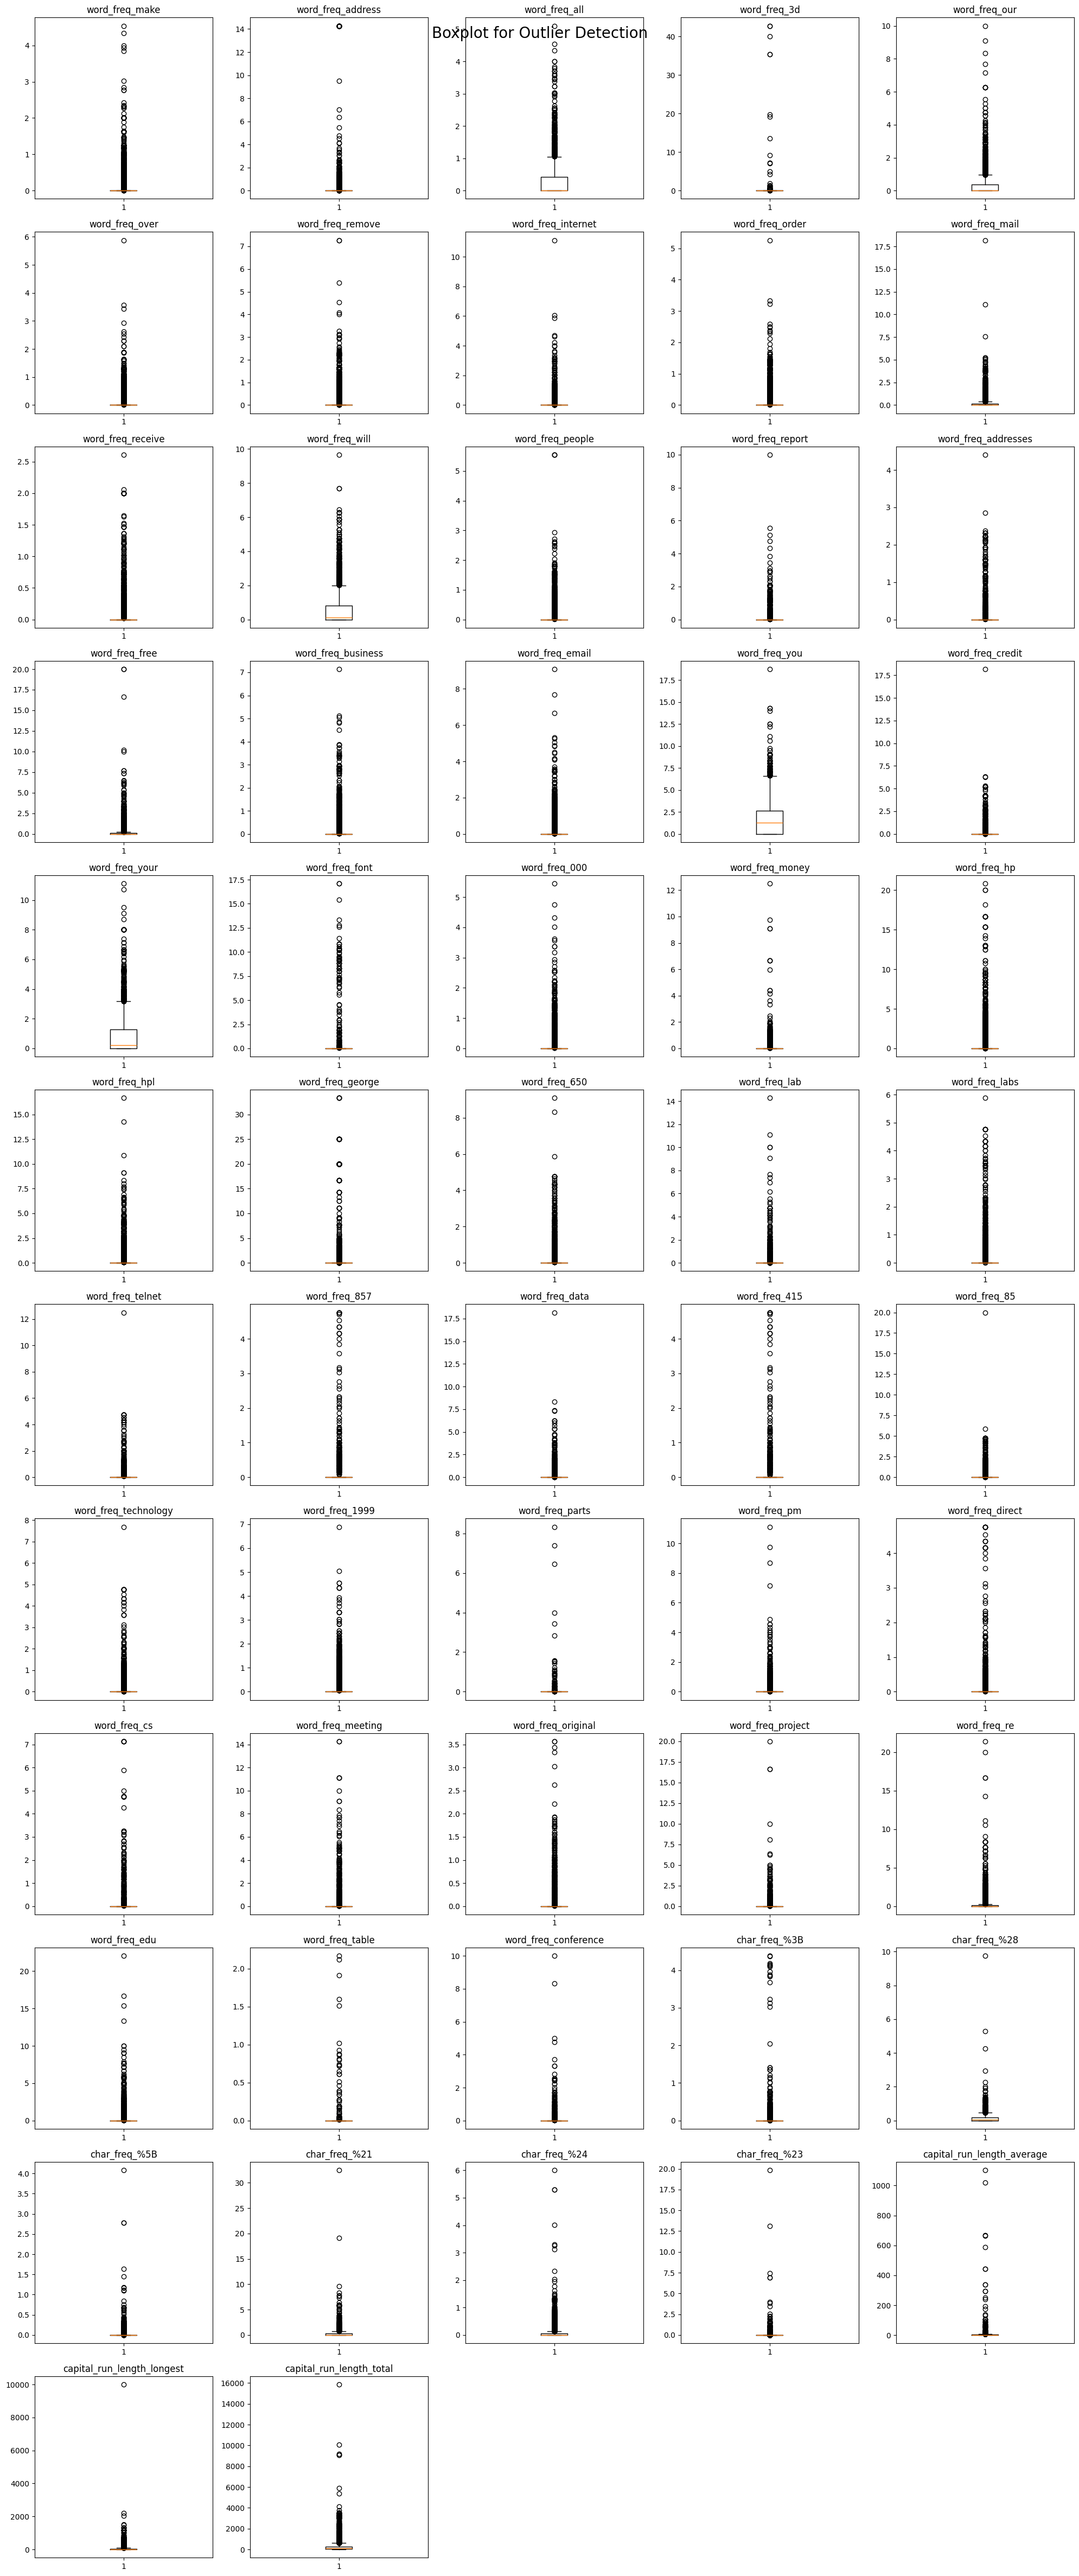

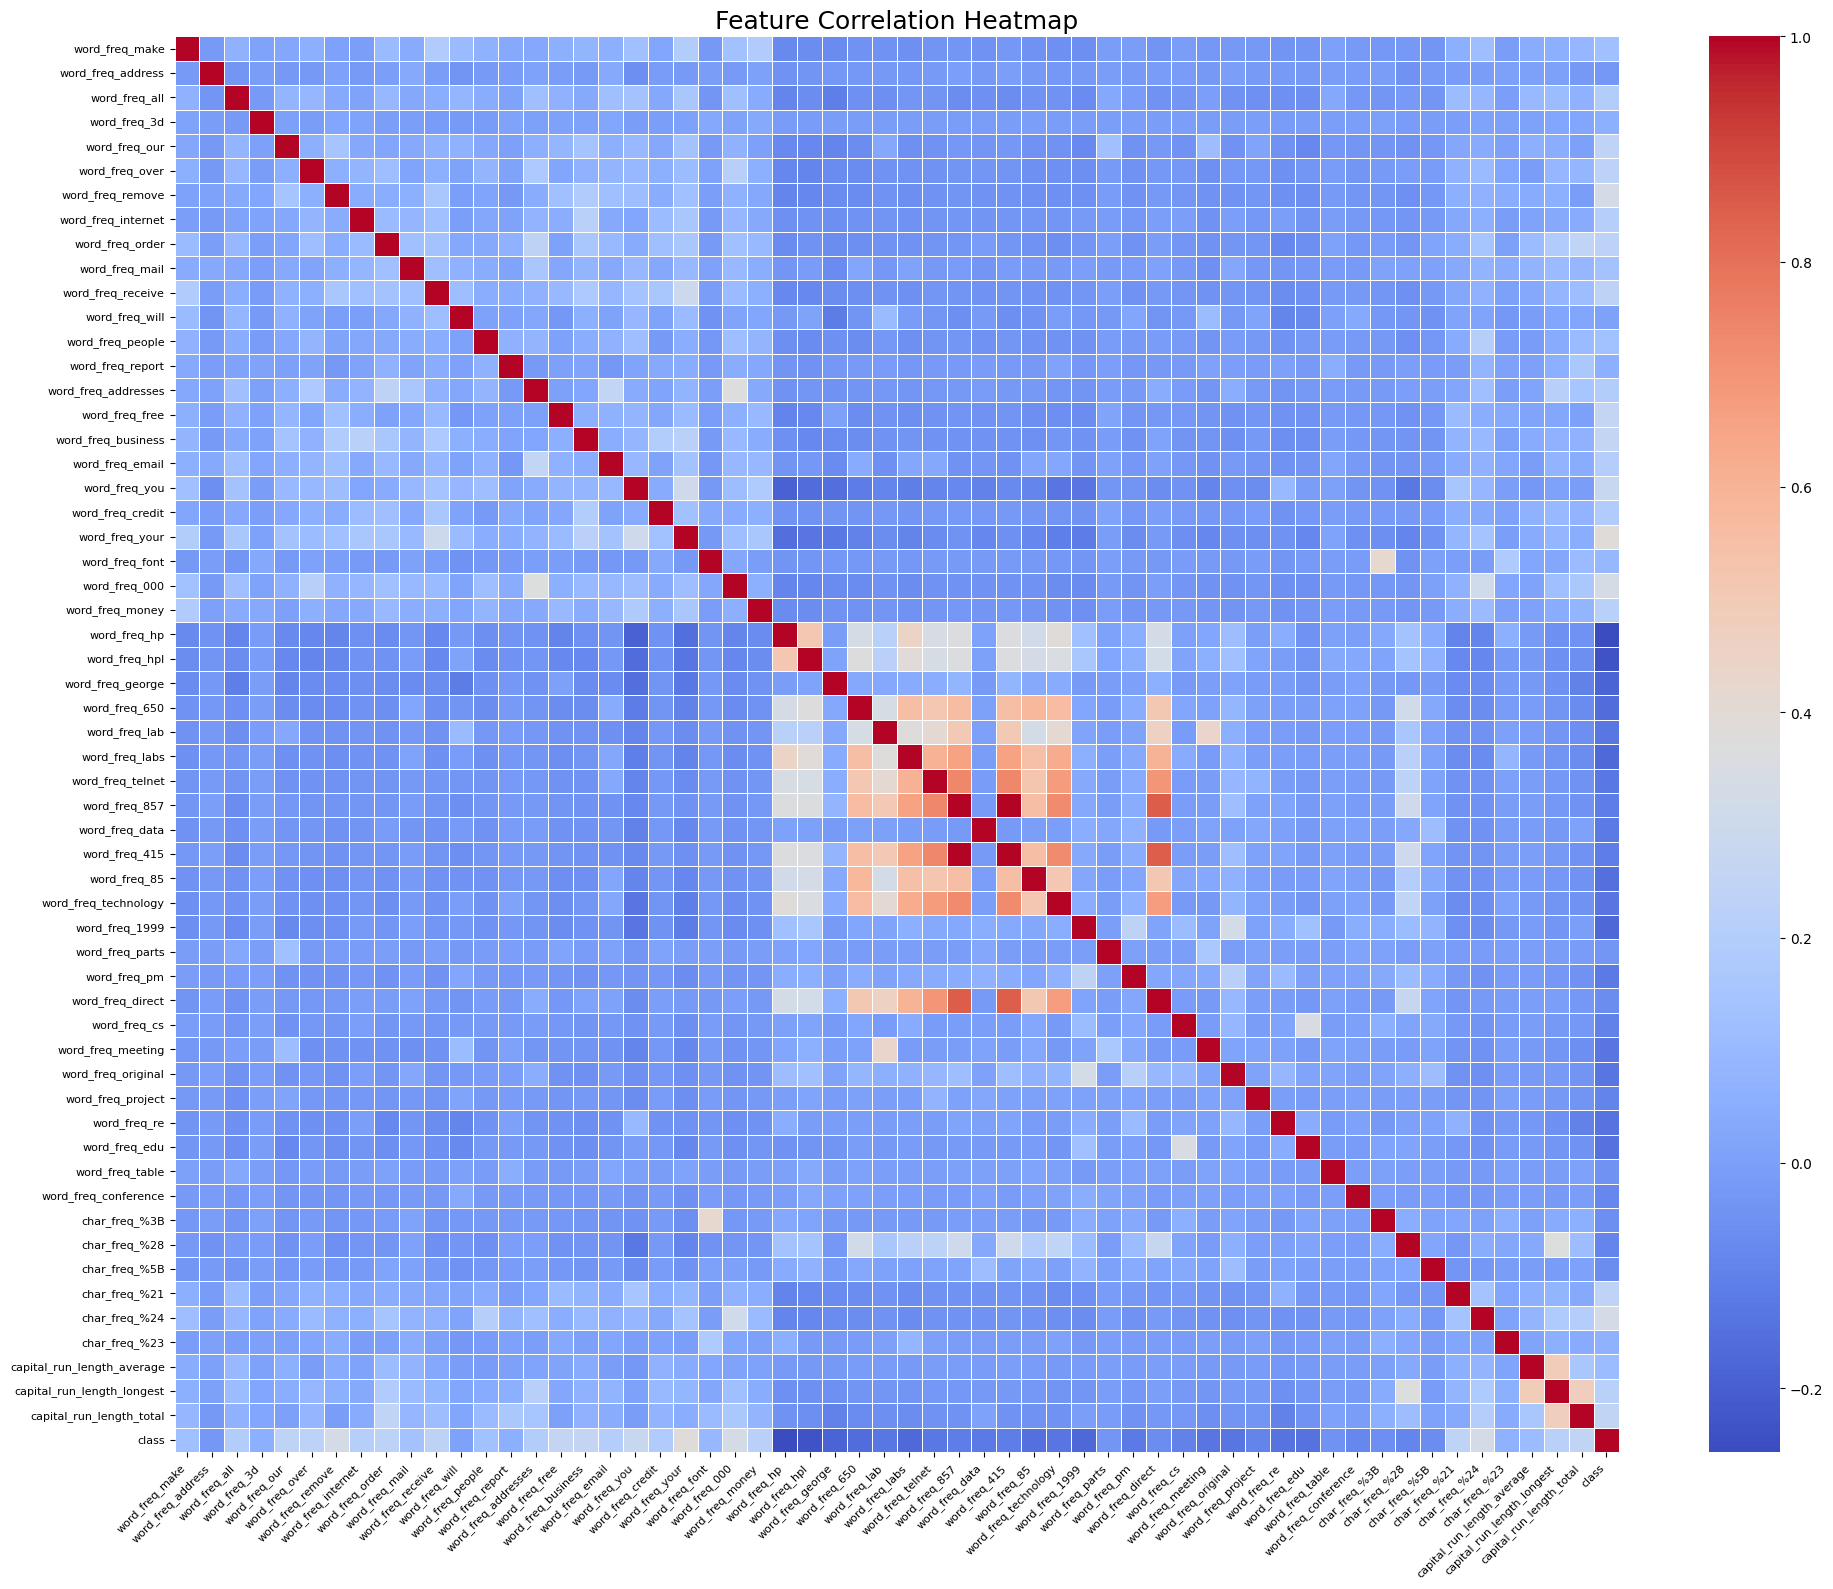

In [9]:
# --- Histogram Subplots ---
n_cols = 5  # Number of plots per row
n_rows = int(np.ceil(len(numerical_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    df[col].hist(ax=axes[i], bins=30)
    axes[i].set_title(col)

# Turn off unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

fig.suptitle("Histogram of Features", fontsize=20)
plt.tight_layout()
plt.show()

# --- Boxplot Subplots ---
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    axes[i].boxplot(df[col])
    axes[i].set_title(col)

for j in range(i+1, len(axes)):
    axes[j].axis('off')

fig.suptitle("Boxplot for Outlier Detection", fontsize=20)
plt.tight_layout()
plt.show()

# --- Correlation Heatmap ---
plt.figure(figsize=(20, 16))
sns.heatmap(df.corr(), annot=False, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Heatmap", fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()


In [10]:
# Evaluating Model using Performance Metrics

def evaluate_model(y_true, y_pred, is_classification, X, model, dataset_name):
    print(f"\n Evaluation - {dataset_name}")
    if is_classification:
        print("Accuracy :", round(accuracy_score(y_true, y_pred), 4))
        print("Precision:", round(precision_score(y_true, y_pred, average='weighted'), 4))
        print("Recall   :", round(recall_score(y_true, y_pred, average='weighted'), 4))
        print("F1 Score :", round(f1_score(y_true, y_pred, average='weighted'), 4))
        print("\nClassification Report:\n", classification_report(y_true, y_pred))

        # ROC Curve: Only for binary classification
        if len(np.unique(y_true)) == 2 and model is not None and hasattr(model, "predict_proba"):
            y_probs = model.predict_proba(X)[:, 1]
            fpr, tpr, _ = roc_curve(y_true, y_probs)
            auc_score = roc_auc_score(y_true, y_probs)
            print("ROC AUC Score:", round(auc_score, 4))

            # Plot ROC
            plt.figure(figsize=(6, 4))
            plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
            plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title(f"ROC Curve - {dataset_name}")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()
    else:
        n, p = X.shape
        r2 = r2_score(y_true, y_pred)
        adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
        print("Mean Squared Error:", mean_squared_error(y_true, y_pred))
        print("Root Mean Squared Error:", root_mean_squared_error(y_true, y_pred))
        print("Mean Absolute Error:", mean_absolute_error(y_true, y_pred))
        print("R2 Score:", r2)
        print("Adjusted R2 Score:", adjusted_r2)


In [11]:
# Evaluating Model on Test and Validation Sets (Without Performance Metrics)

def plot_actual_vs_predicted(y_true, y_pred, title):
    plt.figure(figsize=(6, 4))
    plt.scatter(y_true, y_pred, alpha=0.5, edgecolor='k')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"Actual vs Predicted - {title}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_residuals(y_true, y_pred, title):
    residuals = y_true - y_pred
    plt.figure(figsize=(6, 4))
    plt.scatter(y_pred, residuals, alpha=0.5, edgecolor='k')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.title(f"Residual Plot - {title}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_residual_distribution(y_true, y_pred, title):
    residuals = y_true - y_pred
    plt.figure(figsize=(6, 4))
    sns.histplot(residuals, kde=True, color='skyblue')
    plt.title(f"Residual Distribution - {title}")
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, title):
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
    plt.title(title)
    plt.show()


Processing GaussianNB

--- GaussianNB (No PCA) ---

 Evaluation - Test Set
Accuracy : 0.8274
Precision: 0.8625
Recall   : 0.8274
F1 Score : 0.8279

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.73      0.83       537
           1       0.72      0.96      0.82       384

    accuracy                           0.83       921
   macro avg       0.84      0.85      0.83       921
weighted avg       0.86      0.83      0.83       921

ROC AUC Score: 0.9101


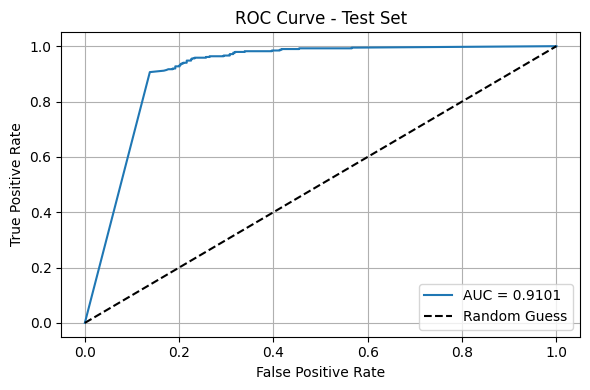

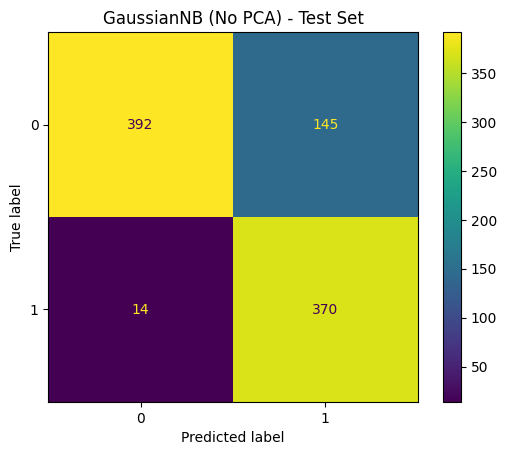

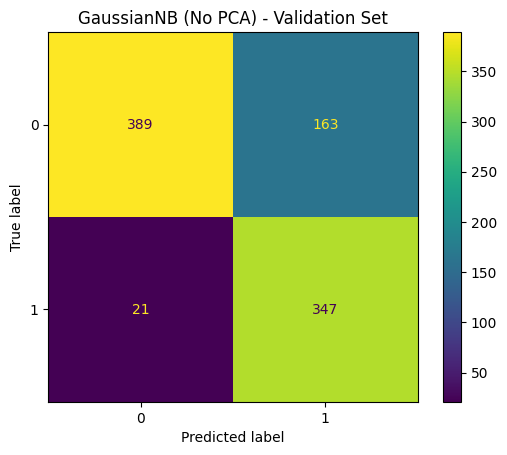

Cross Validation Scores (No PCA): [0.82193268 0.80326087 0.79456522 0.82282609 0.83369565]
Average CV Score (No PCA): 0.8152561015908983

--- GaussianNB (PCA) ---

 Evaluation - Test Set
Accuracy : 0.8393
Precision: 0.8524
Recall   : 0.8393
F1 Score : 0.8404

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.79      0.85       537
           1       0.76      0.90      0.82       384

    accuracy                           0.84       921
   macro avg       0.84      0.85      0.84       921
weighted avg       0.85      0.84      0.84       921

ROC AUC Score: 0.9234


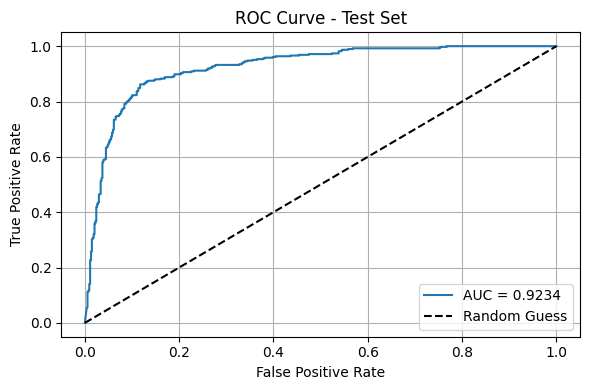

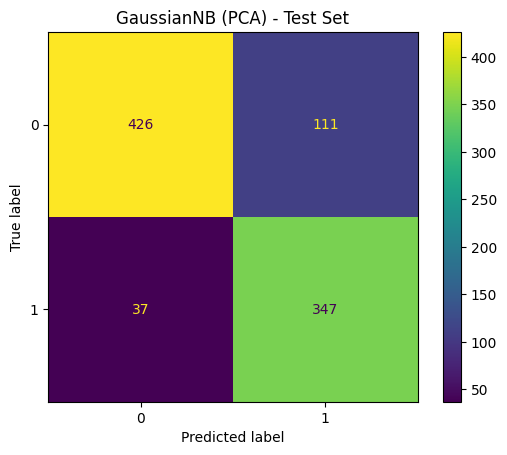

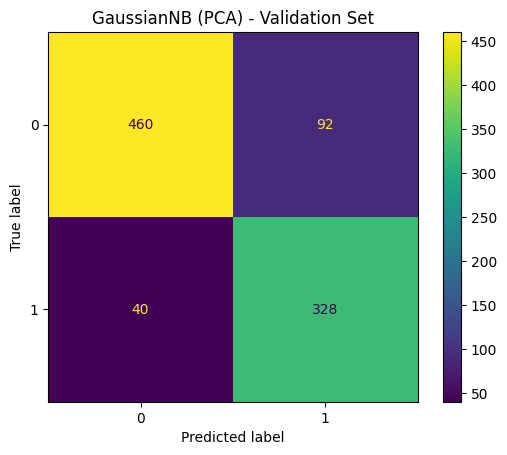

Cross Validation Scores (PCA): [0.8393051  0.87826087 0.88152174 0.88369565 0.87391304]
Average CV Score (PCA): 0.8713392814993155

Processing MultinomialNB

--- MultinomialNB (No PCA) ---

 Evaluation - Test Set
Accuracy : 0.8784
Precision: 0.8842
Recall   : 0.8784
F1 Score : 0.8761

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.96      0.90       537
           1       0.93      0.77      0.84       384

    accuracy                           0.88       921
   macro avg       0.89      0.86      0.87       921
weighted avg       0.88      0.88      0.88       921

ROC AUC Score: 0.9562


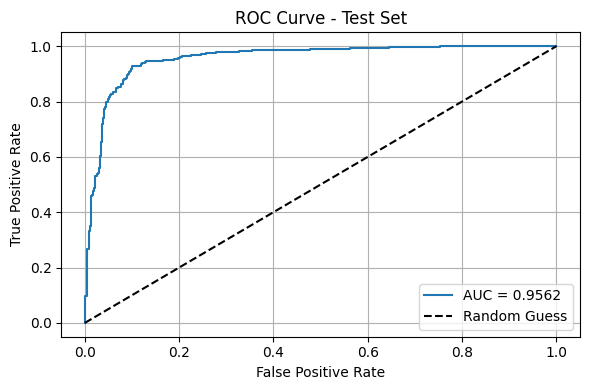

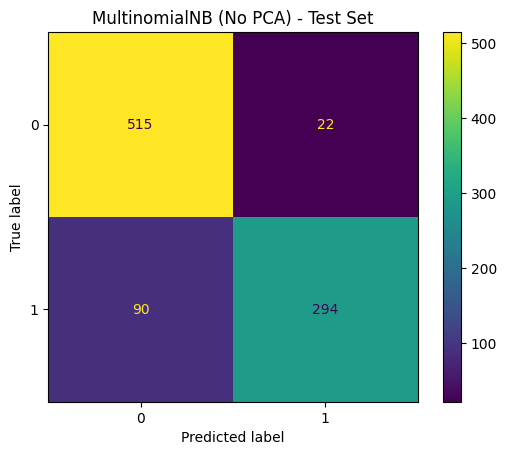

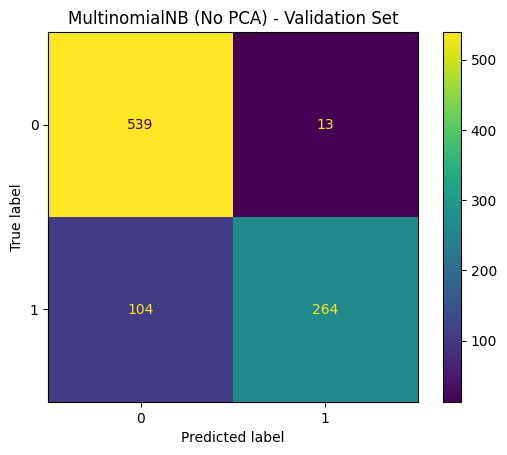

Cross Validation Scores (No PCA): [0.87187839 0.89347826 0.88913043 0.89130435 0.88586957]
Average CV Score (No PCA): 0.8863322003493368

--- MultinomialNB (PCA) ---

 Evaluation - Test Set
Accuracy : 0.5831
Precision: 0.34
Recall   : 0.5831
F1 Score : 0.4295

Classification Report:
               precision    recall  f1-score   support

           0       0.58      1.00      0.74       537
           1       0.00      0.00      0.00       384

    accuracy                           0.58       921
   macro avg       0.29      0.50      0.37       921
weighted avg       0.34      0.58      0.43       921

ROC AUC Score: 0.8797


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

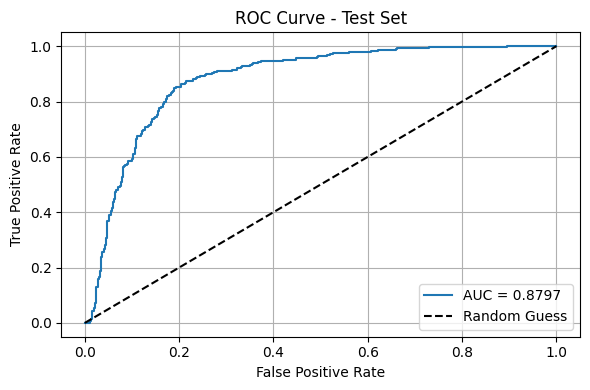

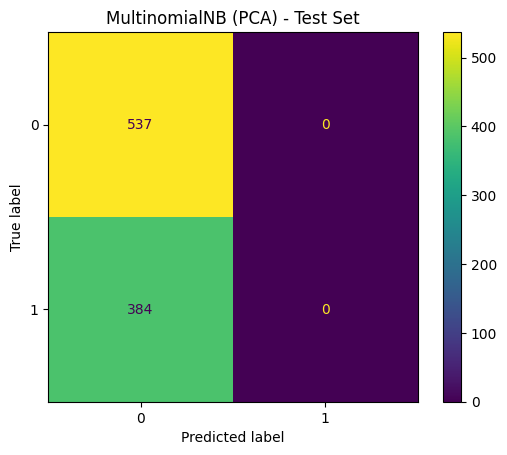

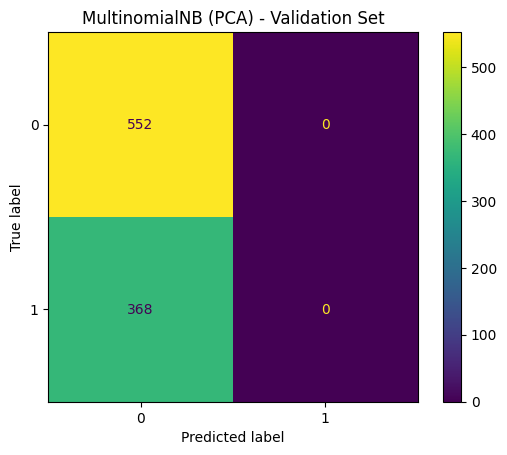

Cross Validation Scores (PCA): [0.57654723 0.60652174 0.61521739 0.62173913 0.60978261]
Average CV Score (PCA): 0.6059616201671151

Processing BernoulliNB

--- BernoulliNB (No PCA) ---

 Evaluation - Test Set
Accuracy : 0.8827
Precision: 0.8836
Recall   : 0.8827
F1 Score : 0.8818

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.93      0.90       537
           1       0.90      0.81      0.85       384

    accuracy                           0.88       921
   macro avg       0.89      0.87      0.88       921
weighted avg       0.88      0.88      0.88       921

ROC AUC Score: 0.9548


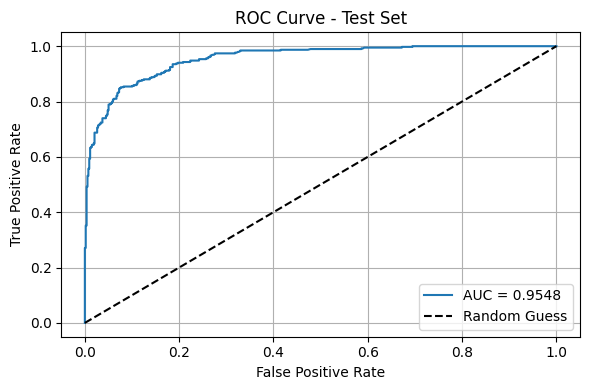

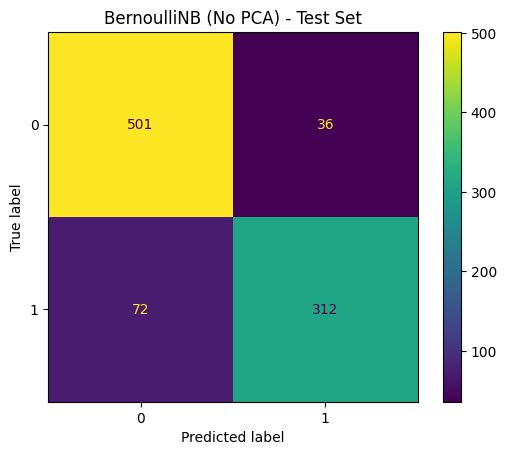

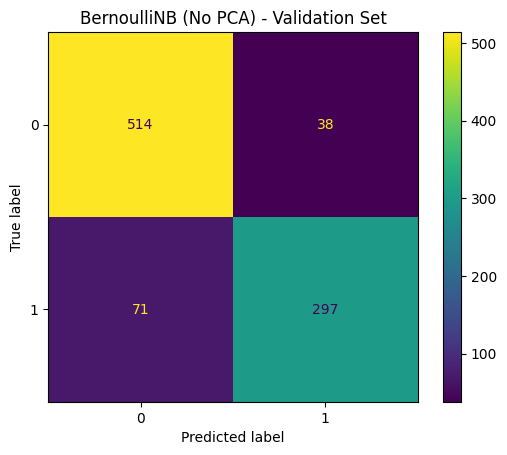

Cross Validation Scores (No PCA): [0.8805646  0.89021739 0.88369565 0.88695652 0.89021739]
Average CV Score (No PCA): 0.8863303120426756

--- BernoulliNB (PCA) ---

 Evaluation - Test Set
Accuracy : 0.8111
Precision: 0.8135
Recall   : 0.8111
F1 Score : 0.8075

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.90      0.85       537
           1       0.83      0.68      0.75       384

    accuracy                           0.81       921
   macro avg       0.82      0.79      0.80       921
weighted avg       0.81      0.81      0.81       921

ROC AUC Score: 0.8874


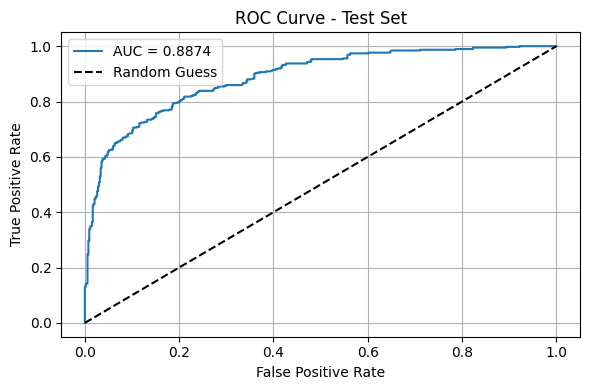

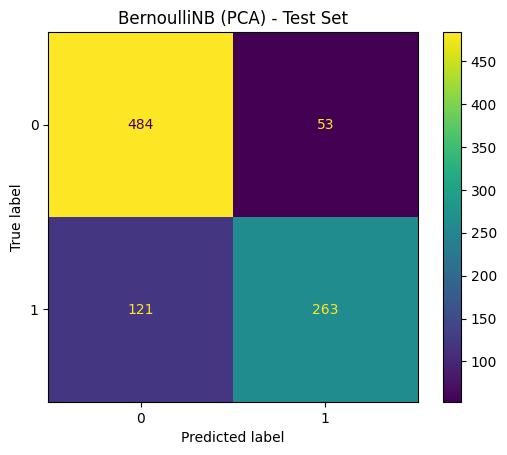

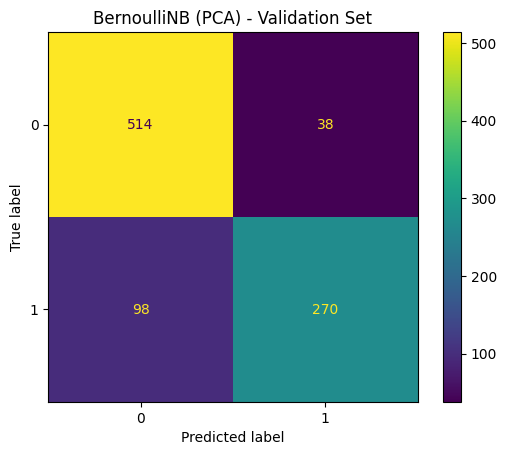

Cross Validation Scores (PCA): [0.83170467 0.82391304 0.85217391 0.83478261 0.83478261]
Average CV Score (PCA): 0.8354713685502526


In [12]:
# Splitting dataset and training model

results = []

def apply_pca(X_train, X_val, X_test, n_components=0.95):
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_val_pca   = pca.transform(X_val)
    X_test_pca  = pca.transform(X_test)
    return X_train_pca, X_val_pca, X_test_pca, pca

models = {
    "GaussianNB": (GaussianNB(), df_gauss),
    "MultinomialNB": (MultinomialNB(), df_multi),
    "BernoulliNB": (BernoulliNB(), df_berno)
}

for name, (model, data) in models.items():
    print(f"\n{'='*40}\nProcessing {name}\n{'='*40}")

    X = data.drop(columns=[target])
    y = data[target]

    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # ---------------- Non-PCA ----------------
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    print(f"\n--- {name} (No PCA) ---")
    evaluate_model(y_test, y_test_pred, True, X_test, model, "Test Set")
    plot_confusion_matrix(y_test, y_test_pred, f"{name} (No PCA) - Test Set")
    plot_confusion_matrix(y_val, y_val_pred, f"{name} (No PCA) - Validation Set")

    # Cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')
    print("Cross Validation Scores (No PCA):", cv_scores)
    print("Average CV Score (No PCA):", np.mean(cv_scores))

    results.append((name, "No PCA", accuracy_score(y_test, y_test_pred), np.mean(cv_scores)))

    # ---------------- PCA ----------------
    # Standard PCA transform
    X_train_pca, X_val_pca, X_test_pca, pca = apply_pca(X_train, X_val, X_test)

    # If model is MultinomialNB, apply MinMaxScaler to make PCA outputs non-negative
    if name == "MultinomialNB":
        scaler = MinMaxScaler()
        X_train_pca = scaler.fit_transform(X_train_pca)
        X_val_pca   = scaler.transform(X_val_pca)
        X_test_pca  = scaler.transform(X_test_pca)
        X_pca_full  = scaler.fit_transform(PCA(n_components=0.95).fit_transform(X))
    else:
        X_pca_full  = PCA(n_components=0.95).fit_transform(X)

    model_pca = model.__class__()  # fresh instance
    model_pca.fit(X_train_pca, y_train)
    y_val_pred_pca = model_pca.predict(X_val_pca)
    y_test_pred_pca = model_pca.predict(X_test_pca)

    print(f"\n--- {name} (PCA) ---")
    evaluate_model(y_test, y_test_pred_pca, True, X_test_pca, model_pca, "Test Set")
    plot_confusion_matrix(y_test, y_test_pred_pca, f"{name} (PCA) - Test Set")
    plot_confusion_matrix(y_val, y_val_pred_pca, f"{name} (PCA) - Validation Set")

    # Cross-validation (PCA)
    cv_scores_pca = cross_val_score(model_pca, X_pca_full, y, cv=kfold, scoring='accuracy')
    print("Cross Validation Scores (PCA):", cv_scores_pca)
    print("Average CV Score (PCA):", np.mean(cv_scores_pca))

    results.append((name, "PCA", accuracy_score(y_test, y_test_pred_pca), np.mean(cv_scores_pca)))